In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
from os.path import join
from matplotlib.colors import LinearSegmentedColormap
from seaborn.palettes import color_palette
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [231]:
DATA_FOLDER = 'data'
RESULTS_FOLDER = 'results'
MUSIC_TASK = 'MusicPreferenceTask'
QUESTIONNAIRE = 'QuestionnaireData.csv'

num_participants = 164
remove_ids = [23, 28, 143, 151, 152, 97, 105, 117]

subject_ids = [i for i in range(1, num_participants + 1) if i not in remove_ids]

In [232]:
questionnaire_data = pd.read_csv(f'{DATA_FOLDER}/{QUESTIONNAIRE}')
questionnaire_data = questionnaire_data[~questionnaire_data['subj'].isin(remove_ids)]
questionnaire_data.reset_index(drop=True, inplace=True)
questionnaire_data.shape

(156, 17)

### Music Preference Task Variables
+ ppnr = participant number
+ trialnr = trial number
+ s1.entclass = entropy class of first sequence (from 1 to 11)
+ s1.stimnr = stimulus number of first sequence (from 1 to 20, as there were 20 sequences in each entropy class)
+ s2.entclass = entropy class of second sequence
+ s2.stimnr = stimulus number of second sequence
+ r =  response (1 or 2, for first or second sequence chosen)
+ s1.tone1 = first tone of first sequence (from 1 to 7, 1 = F3, 2 = G3, 3 = A3, 4 = B3, 5 = C4, 6 = D4, 7 = E4)
+ s1.tone2 = second tone of first sequence 
+ s1.tone3 = third tone of first sequence 
+ s1.tone4 = fourth tone of first sequence 
+ s1.tone5 = fifth tone of first sequence 
+ s1.tone6 = sixth tone of first sequence 
+ s1.tone7 = seventh tone of first sequence 
+ s1.sameentropy = same entropy of the first sequence
+ s1.nextentropy = next entropy of the first sequence
+ s1.entropy = average entropy of the first sequence
+ s2.tone1 = first tone of second sequence
+ s2.tone2 = second tone of second sequence 
+ s2.tone3 = third tone of second sequence 
+ s2.tone4 = fourth tone of second sequence 
+ s2.tone5 = fifth tone of second sequence 
+ s2.tone6 = sixth tone of second sequence 
+ s2.tone7 = seventh tone of second sequence 
+ s2.sameentropy = same entropy of the second sequence
+ ts2.nextentropy = next entropy of the second sequence
+ s2.entropy = average entropy of the second sequence

In [233]:
file_path = f'{DATA_FOLDER}/{MUSIC_TASK}/music_ppn01.rtd'
df = pd.read_csv(file_path, delimiter='\t')
df.shape

(110, 27)

In [234]:
music_task_data = pd.DataFrame()

for subject_id in subject_ids:
    file_name = f"music_ppn{'0' + str(subject_id) if subject_id < 10 else str(subject_id)}.rtd"
    file_path = join(DATA_FOLDER, MUSIC_TASK, file_name)
    temp_df = pd.read_csv(file_path, sep="\t", header=0)
    music_task_data = pd.concat([music_task_data, temp_df], ignore_index=True)
music_task_data.shape

(17160, 27)

In [235]:
music_task_data.columns

Index(['ppnr', 'trialnr', 's1.entclass', 's1.stimnr', 's2.entclass',
       's2.stimnr', 'r', 's1.tone1', 's1.tone2', 's1.tone3', 's1.tone4',
       's1.tone5', 's1.tone6', 's1.tone7', 's1.sameentropy', 's1.nextentropy',
       's1.entropy', 's2.tone1', 's2.tone2', 's2.tone3', 's2.tone4',
       's2.tone5', 's2.tone6', 's2.tone7', 's2.sameentropy', 'ts2.nextentropy',
       's2.entropy'],
      dtype='object')

In [236]:
# Add a new column for preference prediction
music_task_data['pref_pred'] = np.where((music_task_data['s1.entclass'] > music_task_data['s2.entclass']) & (music_task_data['r'] == 1), 0,
                                        np.where((music_task_data['s1.entclass'] < music_task_data['s2.entclass']) & (music_task_data['r'] == 2), 0, 
                                                 np.where((music_task_data['s1.entclass'] > music_task_data['s2.entclass']) & (music_task_data['r'] == 2), 1, 
                                                          np.where((music_task_data['s1.entclass'] < music_task_data['s2.entclass']) & (music_task_data['r'] == 1), 1, np.nan))))

In [237]:
# Initialize preference DataFrame
columns = ['ppnr'] + [f'class{i}' for i in range(1, 12)] + ['weighted_sum', 'pref_pred']
preference = pd.DataFrame(columns=columns)
preference['ppnr'] = subject_ids

# Populate the preference DataFrame
for subject_id in subject_ids:
    subject_data = music_task_data[music_task_data['ppnr'] == subject_id]
    for i in range(1, 12):
        preference.loc[preference['ppnr'] == subject_id, f'class{i}'] = len(subject_data[(subject_data['r'] == 1) & (subject_data['s1.entclass'] == i)]) + len(subject_data[(subject_data['r'] == 2) & (subject_data['s2.entclass'] == i)])
    
    preference.loc[preference['ppnr'] == subject_id, 'weighted_sum'] = sum(preference.loc[preference['ppnr'] == subject_id, f'class{i}'] * (12-i) for i in range(1, 12))
    preference.loc[preference['ppnr'] == subject_id, 'pref_pred'] = subject_data['pref_pred'].mean()

## Preference Plot (Entropy Wise)

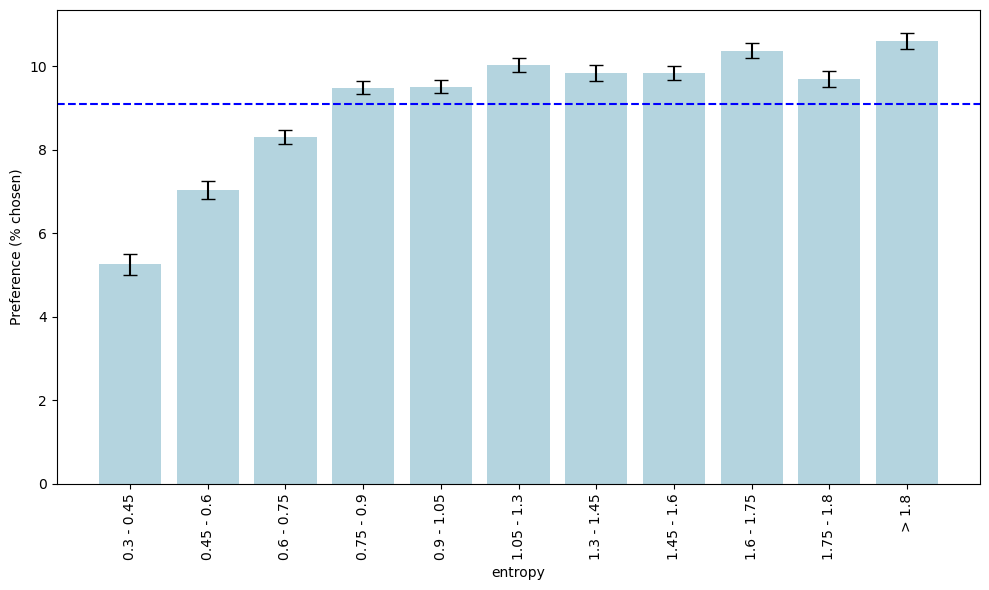

In [238]:
preference_means = preference.iloc[:, 1:12].div(110).mul(100).mean()
preference_sems = preference.iloc[:, 1:12].div(110).mul(100).sem()

# Create a DataFrame for plotting
preference_mean = pd.DataFrame({
    'mean': preference_means.values,
    'sem': preference_sems.values,
    'entropy': ["0.3 - 0.45", "0.45 - 0.6", "0.6 - 0.75", "0.75 - 0.9", "0.9 - 1.05", "1.05 - 1.3", "1.3 - 1.45", "1.45 - 1.6", "1.6 - 1.75", "1.75 - 1.8", "> 1.8"]
})

plt.figure(figsize=(10, 6))
sns.barplot(data=preference_mean, x='entropy', y='mean', color='lightblue')

for index, row in preference_mean.iterrows():
    plt.errorbar(x=index, y=row['mean'], yerr=row['sem'], fmt='none', capsize=5, color='black')

plt.xticks(rotation=90)
plt.ylabel('Preference (% chosen)')
plt.axhline(y=100/11, linestyle='--', color='blue')  # Adding a dashed line for the average preference
plt.tight_layout()

plt.savefig(f'{RESULTS_FOLDER}/{MUSIC_TASK}/preference_plot.png')

In [239]:
def abbreviate_str(value, prefix):
    lst = []
    for item in value:
        if np.isnan(item):
            lst.append('')
            continue
        item = round(item, 2)
        equal = "="
        if item == 0:
            equal = ""
            item = '<.01'
        item = f"{prefix}{equal}{item}".lstrip("0").replace("-0", "-")
        lst.append(item)
    return lst

## Spearman Correlation between Preference and Autism Scores

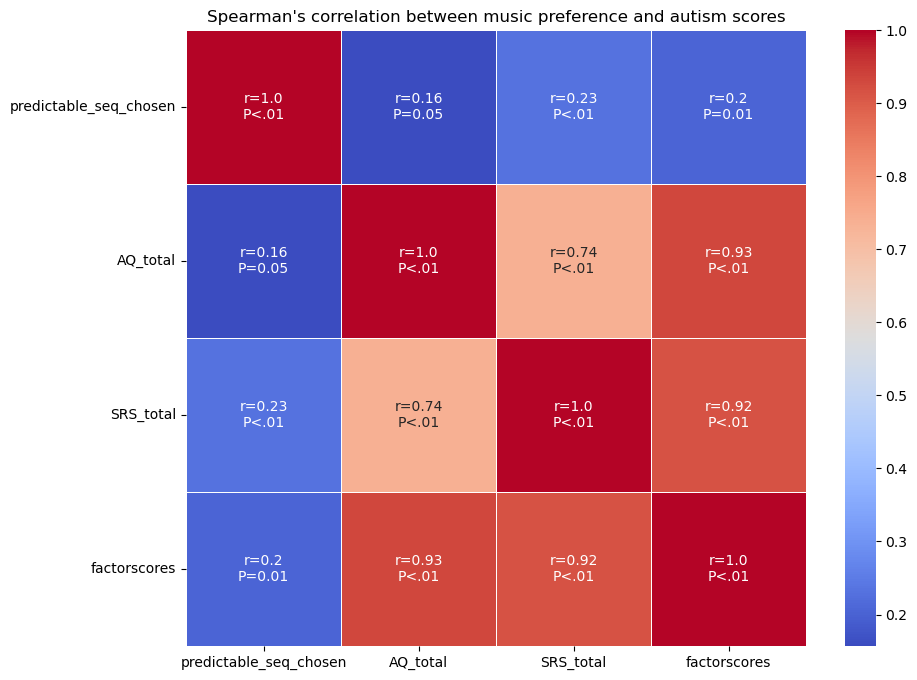

In [240]:
# Prepare the data
corr_data = pd.concat([preference['pref_pred'], questionnaire_data[['AQ_total', 'SRS_total', 'PCA_factor']]], axis=1)
corr_data.columns = ["predictable_seq_chosen", "AQ_total", "SRS_total", "factorscores"]
corr_data = corr_data.apply(pd.to_numeric, errors='coerce')

corr, pval = spearmanr(corr_data.values, nan_policy='omit')
corr_df = pd.DataFrame(corr, index=corr_data.columns, columns=corr_data.columns)
pval_df = pd.DataFrame(pval, index=corr_data.columns, columns=corr_data.columns)

# Melt the correlation DataFrame and annotate
cordata = corr_df.stack().reset_index()
cordata.columns = ['X1', 'X2', 'value']
cordata['labelr'] = abbreviate_str(cordata['value'], 'r')
cordata['labelP'] = abbreviate_str(pval_df.stack().reset_index()[0], 'P')
cordata['labelP'] = abbreviate_str(pval_df.stack().reset_index()[0], 'P')
cordata['label'] = cordata['labelr'] + "\n" + cordata['labelP']

pivot_cordata = cordata.pivot(index='X1', columns='X2', values='label')
pivot_cordata = pivot_cordata.reindex(index=corr_df.index, columns=corr_df.columns)

# Plotting
cmap = color_palette("coolwarm", as_cmap=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=pivot_cordata, fmt='', cmap=cmap, cbar=True, linewidths=.5)
plt.yticks(rotation=0)
plt.title("Spearman's correlation between music preference and autism scores")

# Save the plot
plt.savefig("./results/MusicPreferenceTask/Correlations_of_preferences_with_autism_spearman.png")
plt.show()

## Pearson Correlation between Preference and Autism Scores

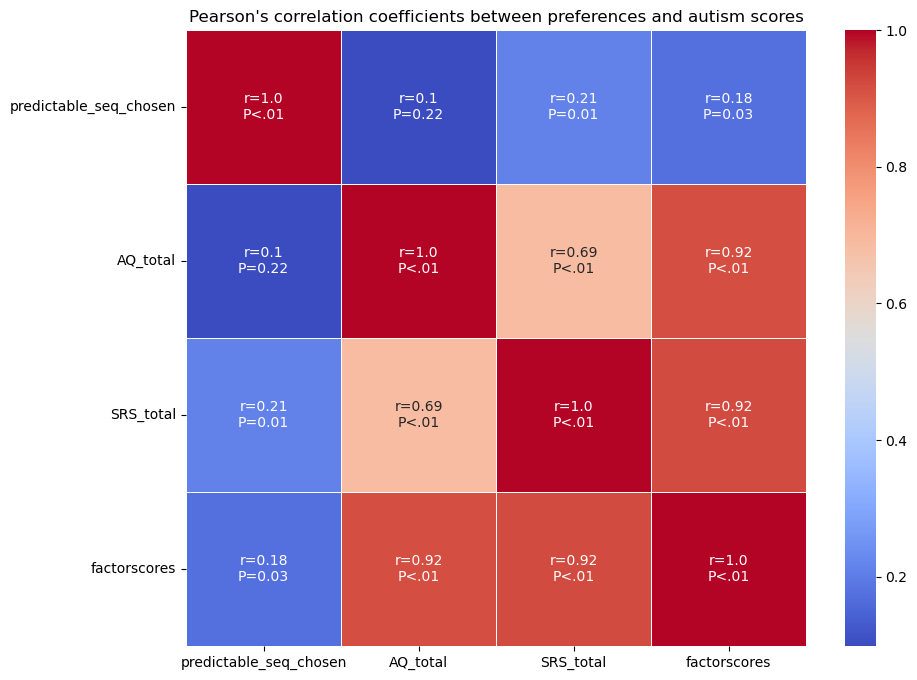

In [241]:
# Prepare the data
corr_data = pd.concat([preference['pref_pred'], questionnaire_data[['AQ_total', 'SRS_total', 'PCA_factor']]], axis=1)
corr_data.columns = ["predictable_seq_chosen", "AQ_total", "SRS_total", "factorscores"]
corr_data = corr_data.apply(pd.to_numeric, errors='coerce')

# Initialize matrices to store correlation coefficients and p-values
corr = np.zeros((corr_data.shape[1], corr_data.shape[1]))
pval = np.zeros((corr_data.shape[1], corr_data.shape[1]))

# Calculate Pearson's correlation for each pair of variables
for i in range(corr_data.shape[1]):
    for j in range(corr_data.shape[1]):
        # Drop NA values for the pair of variables to mimic 'omit' policy
        subset = corr_data.iloc[:, [i, j]].dropna()
        if len(subset) > 1:  # Need at least 2 pairs to calculate correlation
            corr[i, j], pval[i, j] = pearsonr(subset.iloc[:, 0], subset.iloc[:, 1])
        else:
            corr[i, j], pval[i, j] = np.nan, np.nan
            
corr_df = pd.DataFrame(corr, index=corr_data.columns, columns=corr_data.columns)
pval_df = pd.DataFrame(pval, index=corr_data.columns, columns=corr_data.columns)

# Melt the correlation DataFrame and annotate
cordata = corr_df.stack().reset_index()
cordata.columns = ['X1', 'X2', 'value']
cordata['labelr'] = abbreviate_str(cordata['value'], 'r')
cordata['labelP'] = abbreviate_str(pval_df.stack().reset_index()[0], 'P')
cordata['labelP'] = abbreviate_str(pval_df.stack().reset_index()[0], 'P')
cordata['label'] = cordata['labelr'] + "\n" + cordata['labelP']

pivot_cordata = cordata.pivot(index='X1', columns='X2', values='label')
pivot_cordata = pivot_cordata.reindex(index=corr_df.index, columns=corr_df.columns)

# Plotting
cmap = color_palette("coolwarm", as_cmap=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=pivot_cordata, fmt='', cmap=cmap, cbar=True, linewidths=.5)
plt.yticks(rotation=0)
plt.title("Pearson's correlation coefficients between preferences and autism scores")
# Save the plot
plt.savefig("./results/MusicPreferenceTask/Correlations_of_preferences_with_autism_pearson.png")
plt.show()

## Spearman Correlation between Preference and Autism Subscale Scores

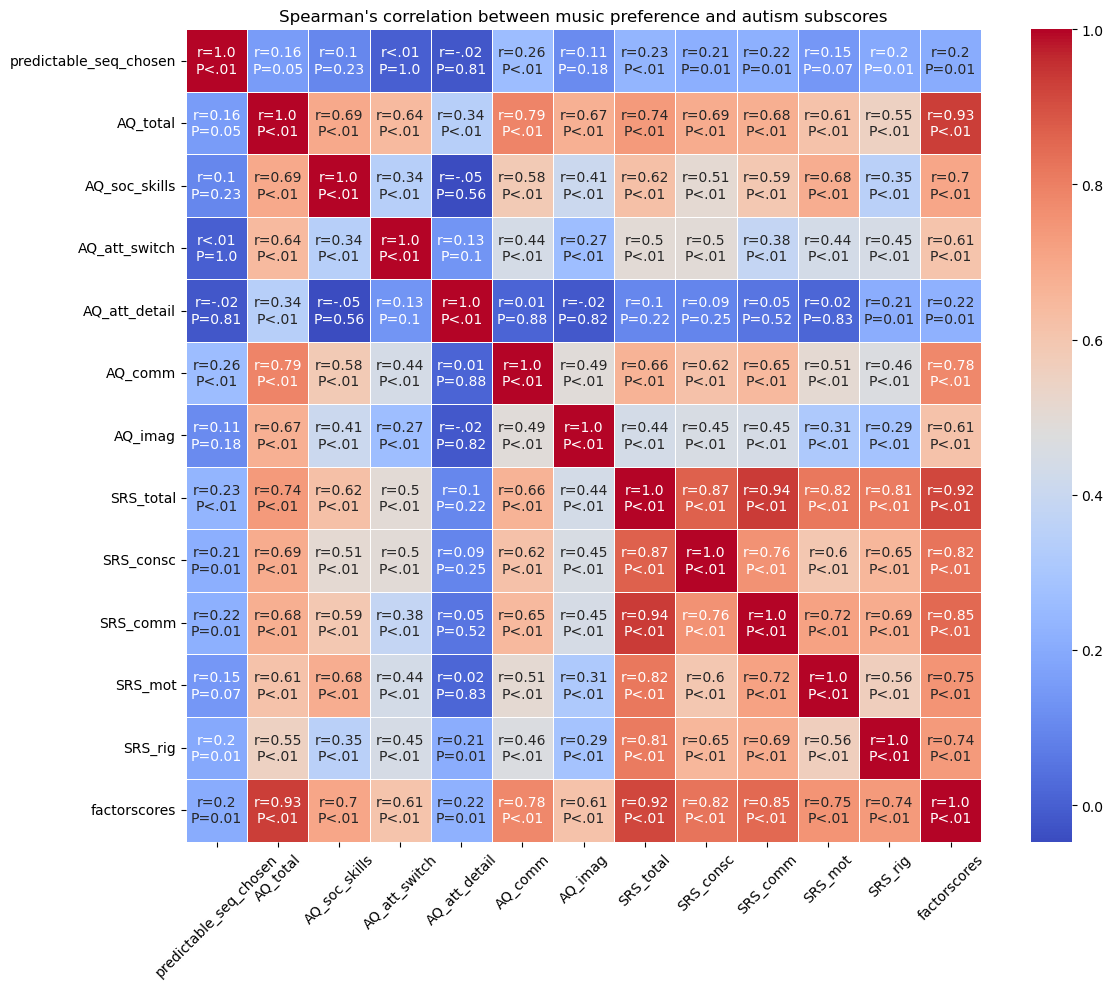

In [242]:
columns_to_use = list(range(4, 10)) + list(range(11, 17))  # Adjust indices as per your dataframe
corr_data = pd.concat([preference[['pref_pred']], questionnaire_data.iloc[:, columns_to_use]], axis=1)
corr_data = corr_data.apply(pd.to_numeric, errors='coerce')
corr_data.columns = ["predictable_seq_chosen", "AQ_total", "AQ_soc_skills", "AQ_att_switch", "AQ_att_detail", "AQ_comm", "AQ_imag", "SRS_total", "SRS_consc", "SRS_comm", "SRS_mot", "SRS_rig", "factorscores"]

# Calculate Spearman correlation and p-values
corr_matrix, pval_matrix = spearmanr(corr_data, nan_policy='omit')

# Create DataFrames for correlations and p-values
corr_df = pd.DataFrame(corr_matrix, index=corr_data.columns, columns=corr_data.columns)
pval_df = pd.DataFrame(pval_matrix, index=corr_data.columns, columns=corr_data.columns)

# Melt the correlation DataFrame and annotate
cordata = corr_df.stack().reset_index()
cordata.columns = ['X1', 'X2', 'value']
cordata['labelr'] = abbreviate_str(cordata['value'], 'r')
cordata['labelP'] = abbreviate_str(pval_df.stack().reset_index()[0], 'P')
cordata['labelP'] = abbreviate_str(pval_df.stack().reset_index()[0], 'P')
cordata['label'] = cordata['labelr'] + "\n" + cordata['labelP']

pivot_cordata = cordata.pivot(index='X1', columns='X2', values='label')
pivot_cordata = pivot_cordata.reindex(index=corr_df.index, columns=corr_df.columns)

# Plotting
plt.figure(figsize=(12, 10))
ax = sns.heatmap(corr_df, annot=pivot_cordata, fmt='', cmap='coolwarm', cbar=True, linewidths=.5)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title("Spearman's correlation between music preference and autism subscores")
plt.tight_layout()

plt.savefig(f'{RESULTS_FOLDER}/{MUSIC_TASK}/Correlations_of_preferences_with_autism_subscores_spearman.png')
plt.show()

## Pearson Correlation between Preference and Autism Subscale Scores

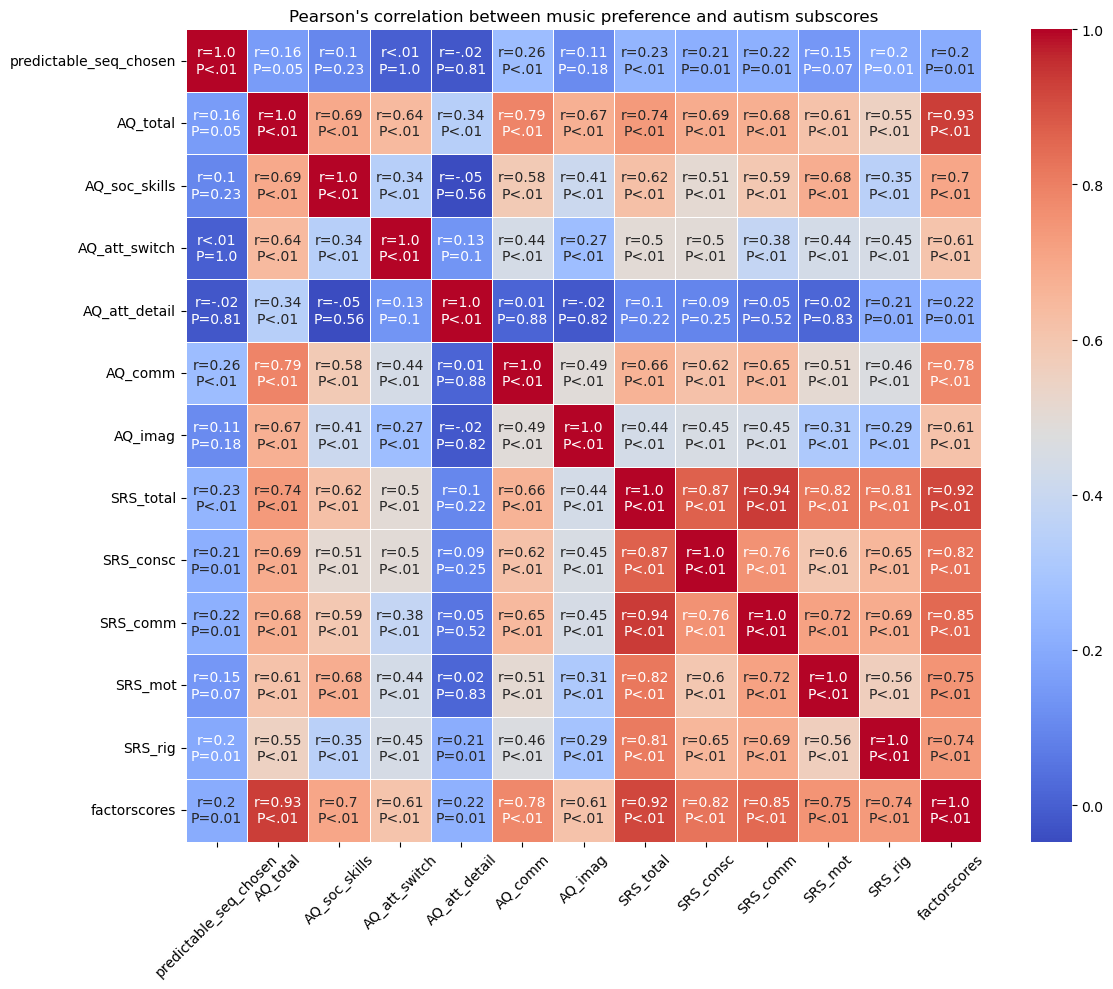

In [243]:
columns_to_use = list(range(4, 10)) + list(range(11, 17))  # Adjust indices as per your dataframe
corr_data = pd.concat([preference[['pref_pred']], questionnaire_data.iloc[:, columns_to_use]], axis=1)
corr_data = corr_data.apply(pd.to_numeric, errors='coerce')
corr_data.columns = ["predictable_seq_chosen", "AQ_total", "AQ_soc_skills", "AQ_att_switch", "AQ_att_detail", "AQ_comm", "AQ_imag", "SRS_total", "SRS_consc", "SRS_comm", "SRS_mot", "SRS_rig", "factorscores"]

# Initialize matrices to store correlation coefficients and p-values
corr = np.zeros((corr_data.shape[1], corr_data.shape[1]))
pval = np.zeros((corr_data.shape[1], corr_data.shape[1]))

# Calculate Pearson's correlation for each pair of variables
for i in range(corr_data.shape[1]):
    for j in range(corr_data.shape[1]):
        # Drop NA values for the pair of variables to mimic 'omit' policy
        subset = corr_data.iloc[:, [i, j]].dropna()
        if len(subset) > 1:  # Need at least 2 pairs to calculate correlation
            corr[i, j], pval[i, j] = pearsonr(subset.iloc[:, 0], subset.iloc[:, 1])
        else:
            corr[i, j], pval[i, j] = np.nan, np.nan

# Create DataFrames for correlations and p-values
corr_df = pd.DataFrame(corr_matrix, index=corr_data.columns, columns=corr_data.columns)
pval_df = pd.DataFrame(pval_matrix, index=corr_data.columns, columns=corr_data.columns)

# Melt the correlation DataFrame and annotate
cordata = corr_df.stack().reset_index()
cordata.columns = ['X1', 'X2', 'value']
cordata['labelr'] = abbreviate_str(cordata['value'], 'r')
cordata['labelP'] = abbreviate_str(pval_df.stack().reset_index()[0], 'P')
cordata['labelP'] = abbreviate_str(pval_df.stack().reset_index()[0], 'P')
cordata['label'] = cordata['labelr'] + "\n" + cordata['labelP']

pivot_cordata = cordata.pivot(index='X1', columns='X2', values='label')
pivot_cordata = pivot_cordata.reindex(index=corr_df.index, columns=corr_df.columns)

# Plotting
plt.figure(figsize=(12, 10))
ax = sns.heatmap(corr_df, annot=pivot_cordata, fmt='', cmap='coolwarm', cbar=True, linewidths=.5)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title("Pearson's correlation between music preference and autism subscores")
plt.tight_layout()

plt.savefig(f'{RESULTS_FOLDER}/{MUSIC_TASK}/Correlations_of_preferences_with_autism_subscores_pearson.png')
plt.show()

## Spearman Correlation between Weighted Sum and Autism Scores

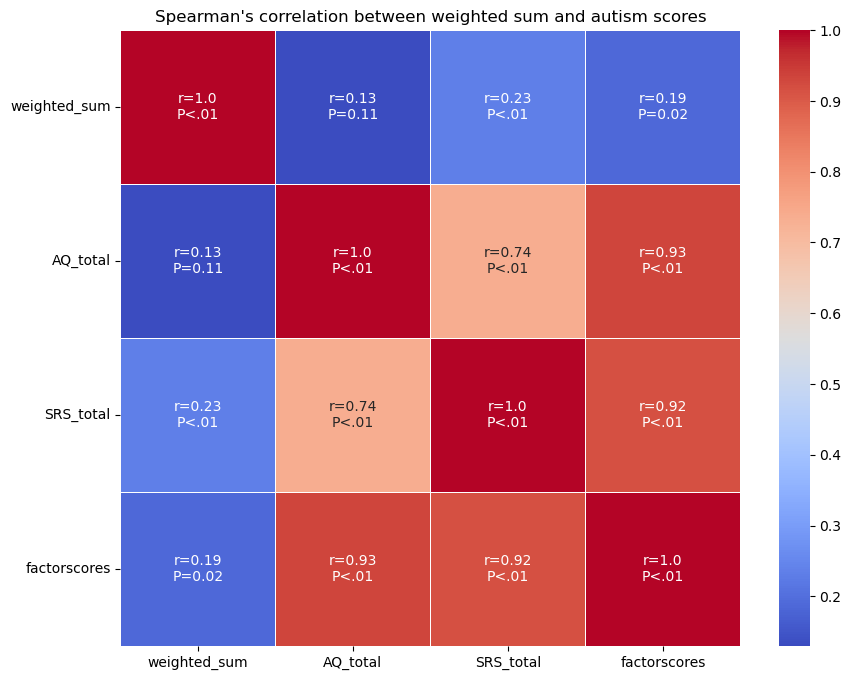

In [244]:
# Prepare the data
corr_data = pd.concat([preference['weighted_sum'], questionnaire_data[['AQ_total', 'SRS_total', 'PCA_factor']]], axis=1)
corr_data.columns = ["weighted_sum", "AQ_total", "SRS_total", "factorscores"]
corr_data = corr_data.apply(pd.to_numeric, errors='coerce')

corr, pval = spearmanr(corr_data.values, nan_policy='omit')
corr_df = pd.DataFrame(corr, index=corr_data.columns, columns=corr_data.columns)
pval_df = pd.DataFrame(pval, index=corr_data.columns, columns=corr_data.columns)

# Melt the correlation DataFrame and annotate
cordata = corr_df.stack().reset_index()
cordata.columns = ['X1', 'X2', 'value']
cordata['labelr'] = abbreviate_str(cordata['value'], 'r')
cordata['labelP'] = abbreviate_str(pval_df.stack().reset_index()[0], 'P')
cordata['labelP'] = abbreviate_str(pval_df.stack().reset_index()[0], 'P')
cordata['label'] = cordata['labelr'] + "\n" + cordata['labelP']

pivot_cordata = cordata.pivot(index='X1', columns='X2', values='label')
pivot_cordata = pivot_cordata.reindex(index=corr_df.index, columns=corr_df.columns)

# Plotting
cmap = color_palette("coolwarm", as_cmap=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=pivot_cordata, fmt='', cmap=cmap, cbar=True, linewidths=.5)
plt.yticks(rotation=0)
plt.title("Spearman's correlation between weighted sum and autism scores")

# Save the plot
plt.savefig("./results/MusicPreferenceTask/Correlations_of_weightedsum_with_autism_spearman.png")
plt.show()

## Pearson Correlation between Weighted Sum and Autism Scores

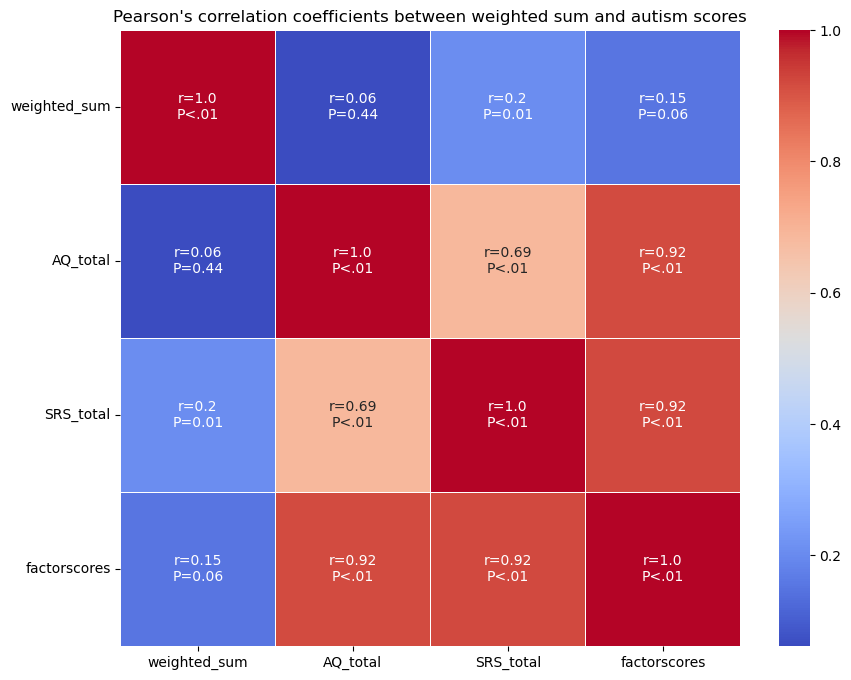

In [245]:
# Prepare the data
corr_data = pd.concat([preference['weighted_sum'], questionnaire_data[['AQ_total', 'SRS_total', 'PCA_factor']]], axis=1)
corr_data.columns = ["weighted_sum", "AQ_total", "SRS_total", "factorscores"]
corr_data = corr_data.apply(pd.to_numeric, errors='coerce')

# Initialize matrices to store correlation coefficients and p-values
corr = np.zeros((corr_data.shape[1], corr_data.shape[1]))
pval = np.zeros((corr_data.shape[1], corr_data.shape[1]))

# Calculate Pearson's correlation for each pair of variables
for i in range(corr_data.shape[1]):
    for j in range(corr_data.shape[1]):
        # Drop NA values for the pair of variables to mimic 'omit' policy
        subset = corr_data.iloc[:, [i, j]].dropna()
        if len(subset) > 1:  # Need at least 2 pairs to calculate correlation
            corr[i, j], pval[i, j] = pearsonr(subset.iloc[:, 0], subset.iloc[:, 1])
        else:
            corr[i, j], pval[i, j] = np.nan, np.nan
            
corr_df = pd.DataFrame(corr, index=corr_data.columns, columns=corr_data.columns)
pval_df = pd.DataFrame(pval, index=corr_data.columns, columns=corr_data.columns)

# Melt the correlation DataFrame and annotate
cordata = corr_df.stack().reset_index()
cordata.columns = ['X1', 'X2', 'value']
cordata['labelr'] = abbreviate_str(cordata['value'], 'r')
cordata['labelP'] = abbreviate_str(pval_df.stack().reset_index()[0], 'P')
cordata['labelP'] = abbreviate_str(pval_df.stack().reset_index()[0], 'P')
cordata['label'] = cordata['labelr'] + "\n" + cordata['labelP']

pivot_cordata = cordata.pivot(index='X1', columns='X2', values='label')
pivot_cordata = pivot_cordata.reindex(index=corr_df.index, columns=corr_df.columns)

# Plotting
cmap = color_palette("coolwarm", as_cmap=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=pivot_cordata, fmt='', cmap=cmap, cbar=True, linewidths=.5)
plt.yticks(rotation=0)
plt.title("Pearson's correlation coefficients between weighted sum and autism scores")
# Save the plot
plt.savefig("./results/MusicPreferenceTask/Correlations_of_weightedsum_with_autism_pearson.png")
plt.show()

# Regression Fit

In [246]:
def get_vif(exogs, data):
    '''Return VIF (variance inflation factor) DataFrame

    Args:
    exogs (list): list of exogenous/independent variables
    data (DataFrame): the df storing all variables

    Returns:
    VIF and Tolerance DataFrame for each exogenous variable

    Notes:
    Assume we have a list of exogenous variable [X1, X2, X3, X4].
    To calculate the VIF and Tolerance for each variable, we regress
    each of them against other exogenous variables. For instance, the
    regression model for X3 is defined as:
                        X3 ~ X1 + X2 + X4
    And then we extract the R-squared from the model to calculate:
                    VIF = 1 / (1 - R-squared)
                    Tolerance = 1 - R-squared
    The cutoff to detect multicollinearity:
                    VIF > 10 or Tolerance < 0.1
    '''

    # initialize dictionaries
    vif_dict, tolerance_dict = {}, {}

    # create formula for each exogenous variable
    for exog in exogs:
        not_exog = [i for i in exogs if i != exog]
        formula = f"{exog} ~ {' + '.join(not_exog)}"

        # extract r-squared from the fit
        r_squared = smf.ols(formula, data=data).fit().rsquared

        # calculate VIF
        vif = 1/(1 - r_squared)
        vif_dict[exog] = vif

        # calculate tolerance
        tolerance = 1 - r_squared
        tolerance_dict[exog] = tolerance

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

    return df_vif

### First Model
+ IV: AQ Total Score, SRS Total Score, PCA factor
+ DV: Preference

In [247]:
corr_data = pd.concat([preference['pref_pred'], questionnaire_data[['AQ_total', 'SRS_total', 'PCA_factor']]], axis=1)
corr_data.columns = ["predictable_seq_chosen", "AQ_total", "SRS_total", "factorscores"]
corr_data = corr_data.apply(pd.to_numeric, errors='coerce')

# Linear regression (equivalent to R's lm())
model_orig = smf.ols('predictable_seq_chosen ~ AQ_total + SRS_total + factorscores', data=corr_data).fit()

print(model_orig.summary())

                              OLS Regression Results                              
Dep. Variable:     predictable_seq_chosen   R-squared:                       0.047
Model:                                OLS   Adj. R-squared:                  0.034
Method:                     Least Squares   F-statistic:                     3.634
Date:                    Thu, 11 Apr 2024   Prob (F-statistic):             0.0288
Time:                            19:19:05   Log-Likelihood:                 149.36
No. Observations:                     151   AIC:                            -292.7
Df Residuals:                         148   BIC:                            -283.7
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercep

In [248]:
def plot_effect(fit, predictor, data, file_name):
    # Predicting with confidence intervals
    prstd, iv_l, iv_u = wls_prediction_std(fit)
    
    # Sorting values for plotting
    data_sorted = data.sort_values(by=[predictor])
    pred = fit.predict(data_sorted)
    
    plt.figure(figsize=(10, 6))
    plt.plot(data_sorted[predictor], pred, 'r-', label='Linear regression')
    plt.fill_between(data_sorted[predictor], iv_l[data_sorted.index], iv_u[data_sorted.index], color='red', alpha=0.1)
    plt.scatter(data[predictor], data['predictable_seq_chosen'], facecolors='none', edgecolors='b', label='Data points')
    plt.xlabel(predictor)
    plt.ylabel('Predictable Sequence Chosen')
    plt.title(f'Effect of {predictor} on Predictable Sequence Chosen')
    plt.legend()
    plt.savefig(f'{file_name}')
    plt.show()

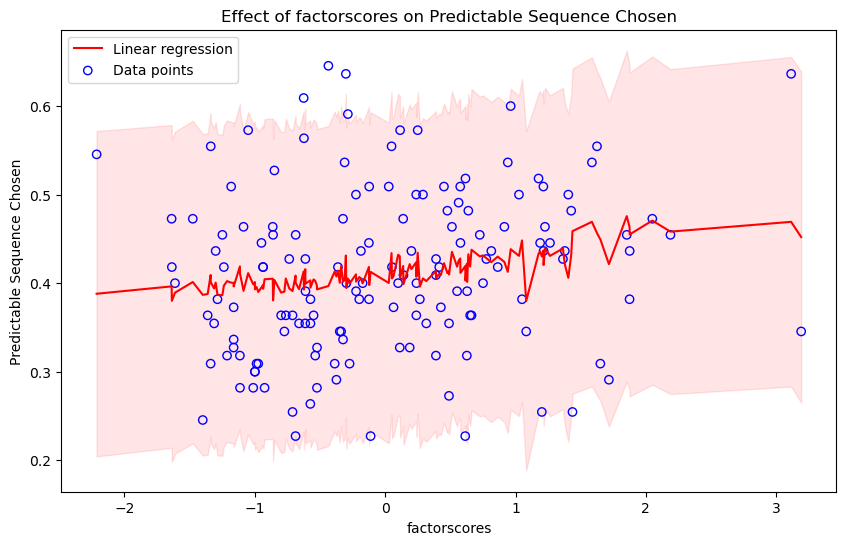

In [249]:
plot_effect(model_orig, 'factorscores', corr_data.dropna(), f"{RESULTS_FOLDER}/{MUSIC_TASK}/LM_Totals_vs_Preferences.png")

### Second Model
+ IV: AQ Total Score, SRS Total Score
+ DV: Preference

In [250]:
# Linear regression (equivalent to R's lm())
fitScores_orig = smf.ols('predictable_seq_chosen ~ AQ_total + SRS_total', data=corr_data).fit()

print(fitScores_orig.summary())

vif_data = pd.DataFrame()
vif_data["feature"] = corr_data.columns[1:3]  # Exclude the dependent variable

print(vif_data)

get_vif(['AQ_total', 'SRS_total'], corr_data)

                              OLS Regression Results                              
Dep. Variable:     predictable_seq_chosen   R-squared:                       0.047
Model:                                OLS   Adj. R-squared:                  0.034
Method:                     Least Squares   F-statistic:                     3.634
Date:                    Thu, 11 Apr 2024   Prob (F-statistic):             0.0288
Time:                            19:19:05   Log-Likelihood:                 149.36
No. Observations:                     151   AIC:                            -292.7
Df Residuals:                         148   BIC:                            -283.7
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

,VIF,Tolerance
AQ_total,1.898988,0.526596
SRS_total,1.898988,0.526596


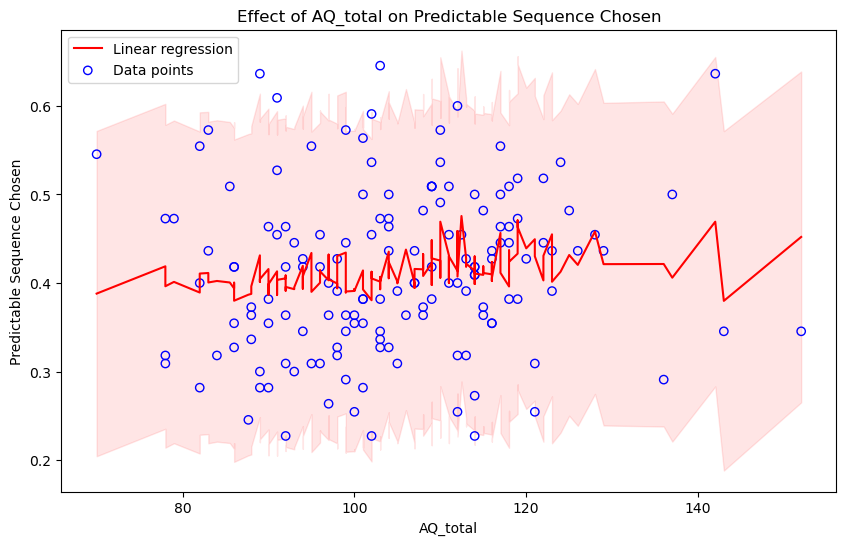

In [251]:
plot_effect(fitScores_orig, 'AQ_total', corr_data.dropna(), f"{RESULTS_FOLDER}/{MUSIC_TASK}/LM_AQTotal_vs_Preferences.png")

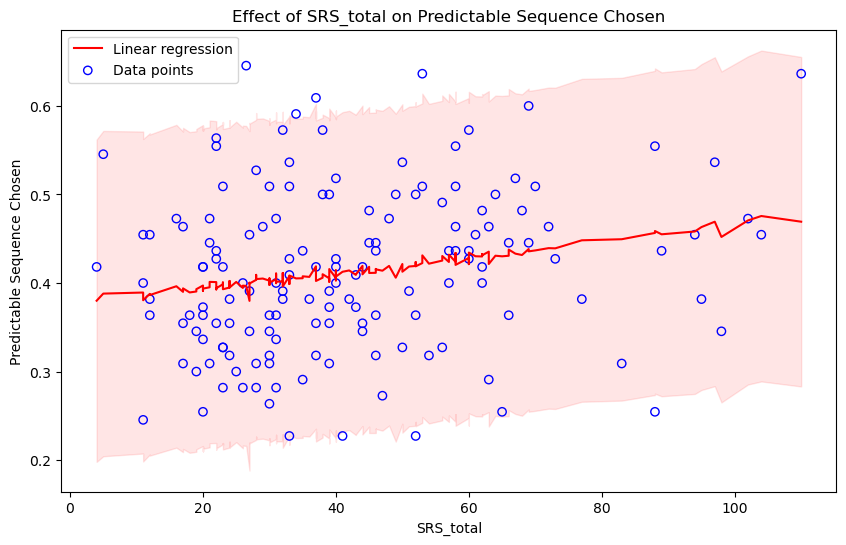

In [252]:
plot_effect(fitScores_orig, 'SRS_total', corr_data.dropna(), f"{RESULTS_FOLDER}/{MUSIC_TASK}/LM_SRSTotal_vs_Preferences.png")

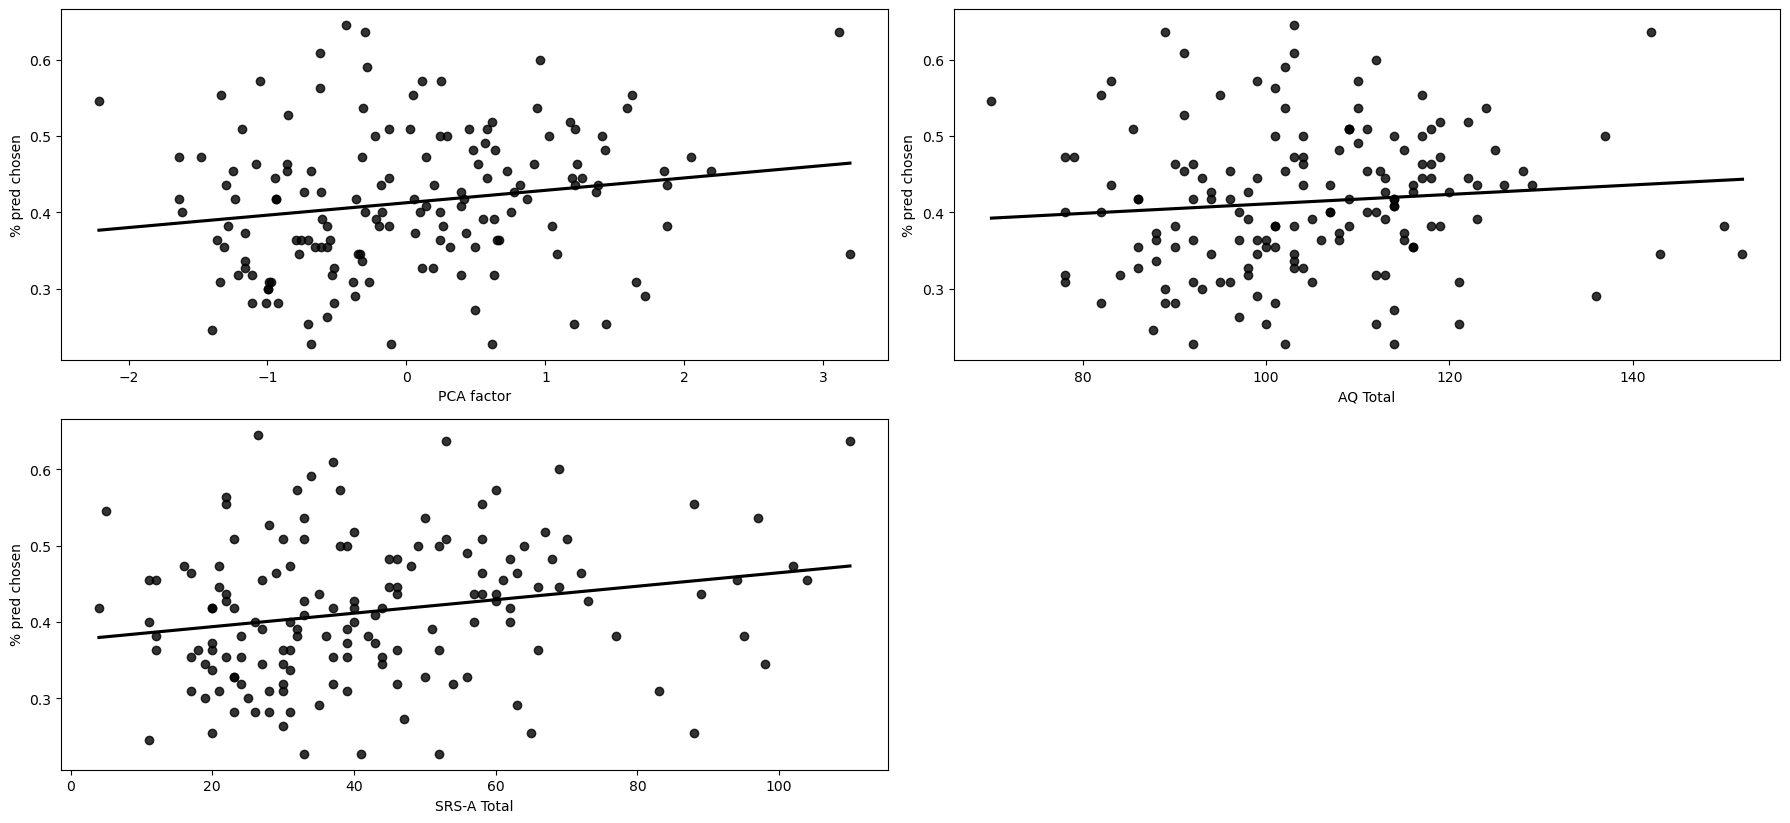

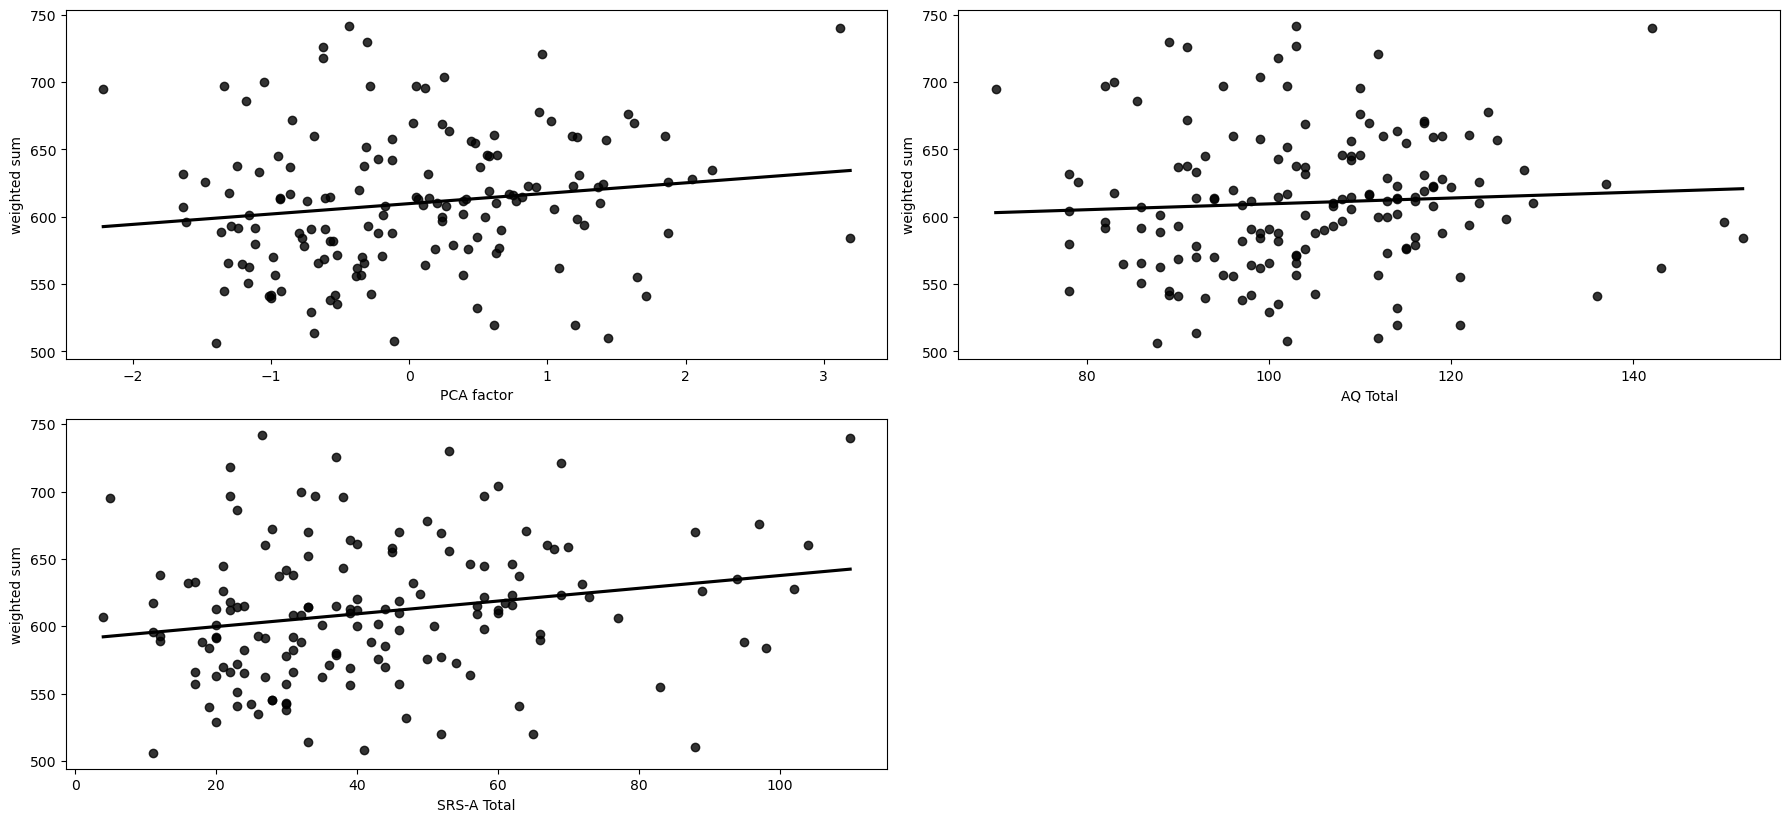

In [253]:
plt.figure(figsize=(18, 12))

corr_data = pd.concat([preference['pref_pred'], questionnaire_data[['AQ_total', 'SRS_total', 'PCA_factor']]], axis=1)
corr_data.columns = ["predictable_seq_chosen", "AQ_total", "SRS_total", "factorscores"]
corr_data = corr_data.apply(pd.to_numeric, errors='coerce')

# Plot 1: factorscores vs predictable_seq_chosen
plt.subplot(3, 2, 1)
sns.regplot(x='factorscores', y='predictable_seq_chosen', data=corr_data, ci=None, color='black')
plt.xlabel('PCA factor')
plt.ylabel('% pred chosen')

# Plot 2: AQ_total vs predictable_seq_chosen
plt.subplot(3, 2, 2)
sns.regplot(x='AQ_total', y='predictable_seq_chosen', data=corr_data, ci=None, color='black')
plt.xlabel('AQ Total')
plt.ylabel('% pred chosen')

# Plot 3: SRS_total vs predictable_seq_chosen
plt.subplot(3, 2, 3)
sns.regplot(x='SRS_total', y='predictable_seq_chosen', data=corr_data, ci=None, color='black')
plt.xlabel('SRS-A Total')
plt.ylabel('% pred chosen')

# Save the figure
plt.tight_layout()
plt.savefig(f"{RESULTS_FOLDER}/{MUSIC_TASK}/Prefpred_vs_Totals.png")
plt.show()

# Assuming 'corr_data' has been updated for weighted_sum as in your R code
# Plot for weighted_sum
plt.figure(figsize=(18, 12))
corr_data = pd.concat([preference['weighted_sum'], questionnaire_data[['AQ_total', 'SRS_total', 'PCA_factor']]], axis=1)
corr_data.columns = ["weighted_sum", "AQ_total", "SRS_total", "factorscores"]
corr_data = corr_data.apply(pd.to_numeric, errors='coerce')


# Plot 4: factorscores vs weighted_sum
plt.subplot(3, 2, 1)
sns.regplot(x='factorscores', y='weighted_sum', data=corr_data, ci=None, color='black')
plt.xlabel('PCA factor')
plt.ylabel('weighted sum')

# Plot 5: AQ_total vs weighted_sum
plt.subplot(3, 2, 2)
sns.regplot(x='AQ_total', y='weighted_sum', data=corr_data, ci=None, color='black')
plt.xlabel('AQ Total')
plt.ylabel('weighted sum')

# Plot 6: SRS_total vs weighted_sum
plt.subplot(3, 2, 3)
sns.regplot(x='SRS_total', y='weighted_sum', data=corr_data, ci=None, color='black')
plt.xlabel('SRS-A Total')
plt.ylabel('weighted sum')

# Save the figure
plt.tight_layout()
plt.savefig(f"{RESULTS_FOLDER}/{MUSIC_TASK}/Weightedsum_vs_Totals.png")
plt.show()

In [254]:
corr_data = pd.concat(
    [
        preference["pref_pred"],
        questionnaire_data[
            [
                "AQ_social",
                "AQ_switch",
                "AQ_detail",
                "AQ_comm",
                "AQ_imag",
                "AQ_binary",
                "SRS_consc",
                "SRS_comm",
                "SRS_motiv",
                "SRS_rigid",
            ]
        ],
    ],
    axis=1,
)
corr_data.columns = [
    "predictable_seq_chosen",
    "AQ_social",
    "AQ_switch",
    "AQ_detail",
    "AQ_comm",
    "AQ_imag",
    "AQ_binary",
    "SRS_consc",
    "SRS_comm",
    "SRS_motiv",
    "SRS_rigid",
]
corr_data = corr_data.apply(pd.to_numeric, errors="coerce")

# Linear regression (equivalent to R's lm())
formula = "predictable_seq_chosen ~ AQ_social + AQ_switch + AQ_detail + AQ_comm + AQ_imag + AQ_binary + SRS_consc + SRS_comm + SRS_motiv + SRS_rigid"
fitSubScores_orig = smf.ols(formula, data=corr_data).fit()

print(fitSubScores_orig.summary())

# Calculate VIF (Variance Inflation Factor, equivalent to vif(fitScores_orig))
vif_data = pd.DataFrame()
vif_data["feature"] = corr_data.columns[1:3]  # Exclude the dependent variable

print(vif_data)

get_vif(["AQ_social", "AQ_switch", "AQ_detail", "AQ_comm", "AQ_imag", "AQ_binary", "SRS_consc", "SRS_comm", "SRS_motiv", "SRS_rigid"], corr_data)

                              OLS Regression Results                              
Dep. Variable:     predictable_seq_chosen   R-squared:                       0.092
Model:                                OLS   Adj. R-squared:                  0.027
Method:                     Least Squares   F-statistic:                     1.414
Date:                    Thu, 11 Apr 2024   Prob (F-statistic):              0.180
Time:                            19:19:07   Log-Likelihood:                 153.00
No. Observations:                     151   AIC:                            -284.0
Df Residuals:                         140   BIC:                            -250.8
Df Model:                              10                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

,VIF,Tolerance
AQ_social,3.063207,0.326455
AQ_switch,2.042268,0.489652
AQ_detail,1.711560,0.584262
AQ_comm,2.845113,0.351480
AQ_imag,2.035597,0.491256
AQ_binary,7.404364,0.135055
SRS_consc,3.177628,0.314700
SRS_comm,4.671118,0.214082
SRS_motiv,3.213595,0.311178
SRS_rigid,3.165717,0.315884


In [255]:
print("AIC for the current model:", fitScores_orig.aic)
print("AIC for the current model:", fitSubScores_orig.aic)

AIC for the current model: -292.71444352792435
AIC for the current model: -284.00677015492784


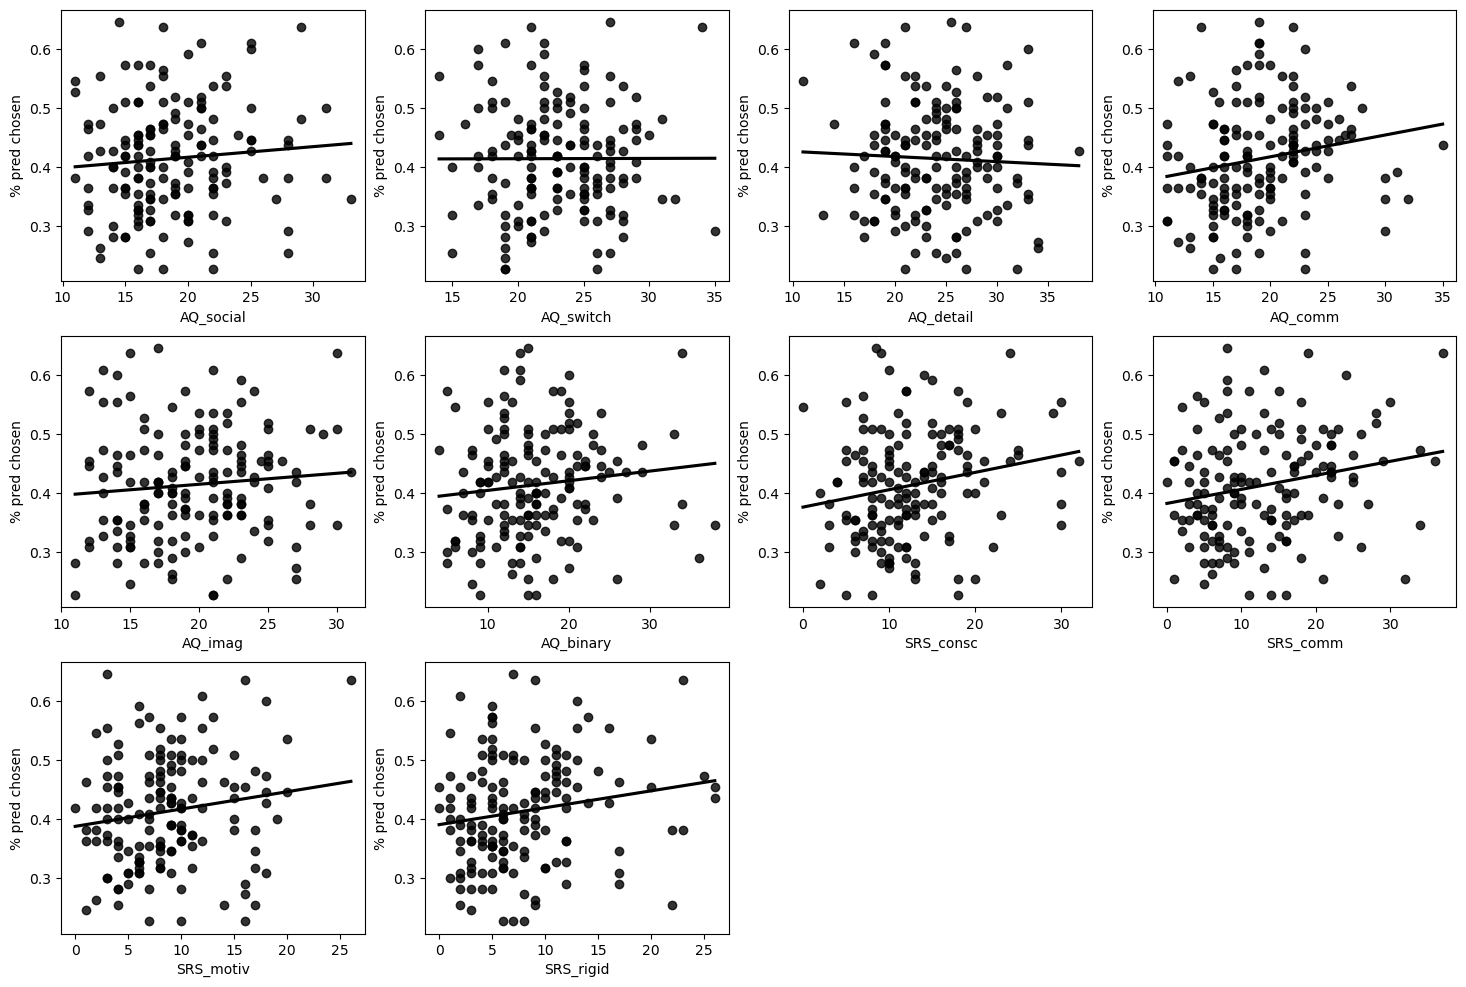

In [256]:
predictors = ['AQ_social', 'AQ_switch', 'AQ_detail', 'AQ_comm', 'AQ_imag', 'AQ_binary', 'SRS_consc', 'SRS_comm', 'SRS_motiv', 'SRS_rigid']
plt.figure(figsize=(18, 12))
for i, predictor in enumerate(predictors):
    plt.subplot(3, 4, i + 1)
    sns.regplot(x=predictor, y="predictable_seq_chosen", data=corr_data, ci=None, color="black")
    plt.xlabel(predictor)
    plt.ylabel("% pred chosen")
    
plt.savefig(f"{RESULTS_FOLDER}/{MUSIC_TASK}/Prefpred_vs_SubScores.png")